In [135]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl

from sklearn.preprocessing import StandardScaler

# Features

In [218]:
df = pd.read_csv('../data/clean.csv', index_col=0)

In [219]:
df['Date'] = pd.to_datetime(df['Date']) 
df['Volume'] = df['Volume'].apply(lambda x: float(x))
df["time_idx"] = df["Date"].dt.year * 365 + df["Date"].dt.day

min_time_idx = df['time_idx'].min()
df["time_idx"] -= min_time_idx
df = df.sort_values("time_idx")

In [220]:
df = df[['Date', 'Product_Code', 'Volume', 'time_idx']]
df

,Date,Product_Code,Volume,time_idx
1450,2012-03-01,Product_0123,120.0,0
2998,2012-05-01,Product_1548,150.0,0
2997,2012-05-01,Product_1539,2500.0,0
2996,2012-05-01,Product_1513,6400.0,0
2995,2012-05-01,Product_1496,4250.0,0
...,...,...,...,...
32636,2015-07-31,Product_1419,1400.0,1125
32637,2015-07-31,Product_1420,1600.0,1125
32638,2015-07-31,Product_1421,500.0,1125
32630,2015-07-31,Product_0984,400.0,1125


# Fusion Transformer

In [221]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


import lightning.pytorch as pl


In [222]:
max_prediction_length = 7
max_encoder_length = 14
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[0:14],
    time_idx="time_idx",
    target="Volume",
    group_ids=["Product_Code"],
    min_encoder_length=max_encoder_length // 4,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Product_Code"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Volume",
    ],
    target_normalizer=GroupNormalizer(
        groups=["Product_Code"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/pytorch_forecasting/data/timeseries.py:1301: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 14 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Product_Code': 'Product_0123'}, {'__grou

AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [215]:
pl.seed_everything(42)

Seed set to 42


42

In [216]:
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 19.0k


/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 250    | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


RuntimeError: index 232 is out of bounds for dimension 0 with size 15

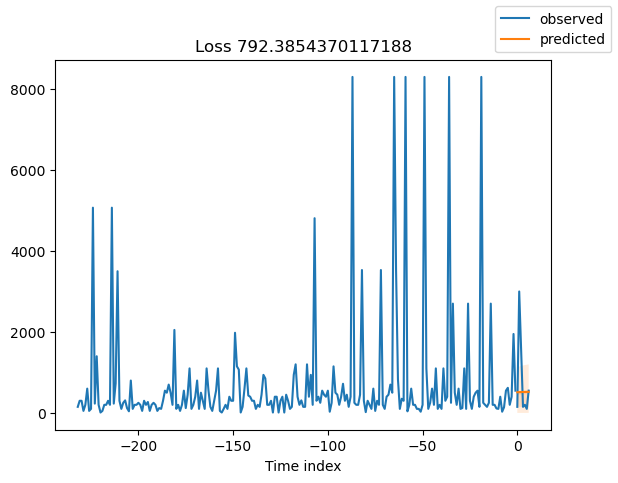

In [217]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [196]:
720 // 2

360